In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Load data

In [2]:
df_result_summer = pd.read_csv("cop_with_T_dataset_R290_summer_pattern.csv").rename(columns={"Temperature": "T"})
df_result_winter = pd.read_csv("cop_with_T_dataset_R290_winter_pattern.csv").rename(columns={"Temperature": "T"})

df_daily_winter = pd.read_csv("schedule_daily_winter.csv", index_col=0)
df_daily_summer = pd.read_csv("schedule_daily_summer.csv", index_col=0)

df_result_summer = df_result_summer.groupby(df_result_summer["Time"] // (3600 * 24)).agg({"cop": "mean", "T": "mean"})
df_result_winter = df_result_winter.groupby(df_result_winter["Time"] // (3600 * 24)).agg({"cop": "mean", "T": "mean"})

In [3]:
df_result_summer["T_feed"] = df_daily_summer["T_feed"]
df_result_summer["heat"] = df_daily_summer["heat_pump"]
df_result_winter["T_feed"] = df_daily_winter["T_feed"]
df_result_winter["heat"] = df_daily_winter["heat_pump"]

## Validate simulation result to input schedule

In [4]:
assert ((df_result_summer["heat"] == 0) == (df_result_summer["cop"] == 0)).any()

In [5]:
assert ((df_result_winter["heat"] == 0) == (df_result_winter["cop"] == 0)).any()

## Heat pump performance indicators

### Annual performance

In [6]:
mask_winter = df_result_winter["heat"] > 0
mask_summer = df_result_summer["heat"] > 0

In [7]:
df_result_summer["heat BHE"] = 0.0
df_result_summer["power"] = 0.0
df_result_summer.loc[mask_summer, "heat BHE"] = ((1 - 1 / df_result_summer.loc[mask_summer, "cop"]) * df_result_summer.loc[mask_summer, "heat"])
df_result_summer.loc[mask_summer, "power"] = df_result_summer.loc[mask_summer, "heat"] - df_result_summer.loc[mask_summer, "heat BHE"]

In [8]:
df_result_winter["heat BHE"] = 0.0
df_result_winter["power"] = 0.0
df_result_winter.loc[mask_winter, "heat BHE"] = ((1 - 1 / df_result_winter.loc[mask_winter, "cop"]) * df_result_winter.loc[mask_winter, "heat"])
df_result_winter.loc[mask_winter, "power"] = df_result_winter.loc[mask_winter, "heat"] - df_result_winter.loc[mask_winter, "heat BHE"]

In [9]:
df_annual_performance = pd.DataFrame(columns=["summer", "winter"], index=["heat", "heat from DUBHE", "work", "annual COP"])
rename = {"heat BHE": "heat from DUBHE", "power": "work"}

for col in ["heat", "heat BHE", "power"]:
    renamed = rename.get(col, col)
    df_annual_performance.loc[renamed, "summer"] = df_result_summer.loc[mask_summer, col].sum() * 24
    df_annual_performance.loc[renamed, "winter"] = df_result_winter.loc[mask_winter, col].sum() * 24

df_annual_performance.loc["annual COP"] = df_annual_performance.loc["heat"] / df_annual_performance.loc["work"]

df_annual_performance = df_annual_performance.transpose()

In [10]:
df_annual_performance

,heat,heat from DUBHE,work,annual COP
summer,3052518.94165,2135684.069278,916834.872372,3.32941
winter,2473338.29127,1682833.953297,790504.337973,3.128811


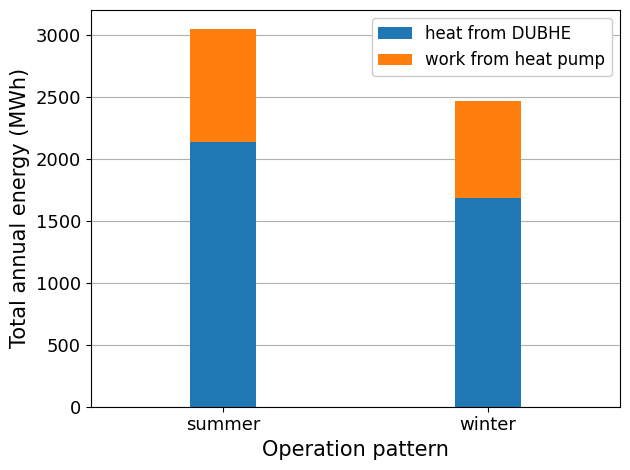

In [11]:
fig, ax = plt.subplots(1)

df_annual_performance = df_annual_performance.rename(columns={"work": "work from heat pump"})

bottom = [0, 0]
for col in ["heat from DUBHE", "work from heat pump"]:
    ax.bar([1, 2], df_annual_performance[col] / 1000, width=0.25, bottom=bottom, label=col)
    bottom = (df_annual_performance[col] / 1000).tolist()

ax.set_xticks([1, 2])
ax.set_xticklabels(["summer", "winter"])
ax.set_xlim([0.5, 2.5])

ax.set_ylabel("Total annual energy (MWh)", fontsize=15)
ax.set_xlabel("Operation pattern", fontsize=15)
ax.yaxis.grid()

ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)

ax.legend(loc="upper right", prop={'size': 12}, framealpha=1)

ax.set_axisbelow(True)

plt.tight_layout()

fig.savefig("annual_energy_totals.pdf")

In [12]:
df_result_summer.loc[mask_summer, ["T_feed", "T", "cop"]].describe()

,T_feed,T,cop
count,217.000000,217.000000,217.000000
mean,64.746491,23.378942,3.580545
std,3.934643,6.937751,0.726466
min,60.000000,14.437833,2.507646
25%,61.358333,17.809831,3.002548
50%,63.562500,21.978524,3.477548
75%,67.829167,27.493110,3.915875
max,75.045833,42.058212,6.019220


In [13]:
df_result_winter.loc[mask_winter, ["T_feed", "T", "cop"]].describe()

,T_feed,T,cop
count,165.000000,165.000000,165.000000
mean,70.155707,24.843991,3.220433
std,3.040602,5.282558,0.441535
min,62.770833,18.644944,2.557015
25%,67.954167,21.147779,2.953366
50%,69.862500,23.274768,3.142451
75%,71.995833,26.339151,3.352419
max,79.066667,44.678917,5.219875


### Share of heat from BHE

In [14]:
df_result_winter["heat BHE"].sum() / df_result_winter["heat"].sum()

0.6803897223587857

In [15]:
df_result_summer["heat BHE"].sum() / df_result_summer["heat"].sum()

0.6996464592365321

## COP over time

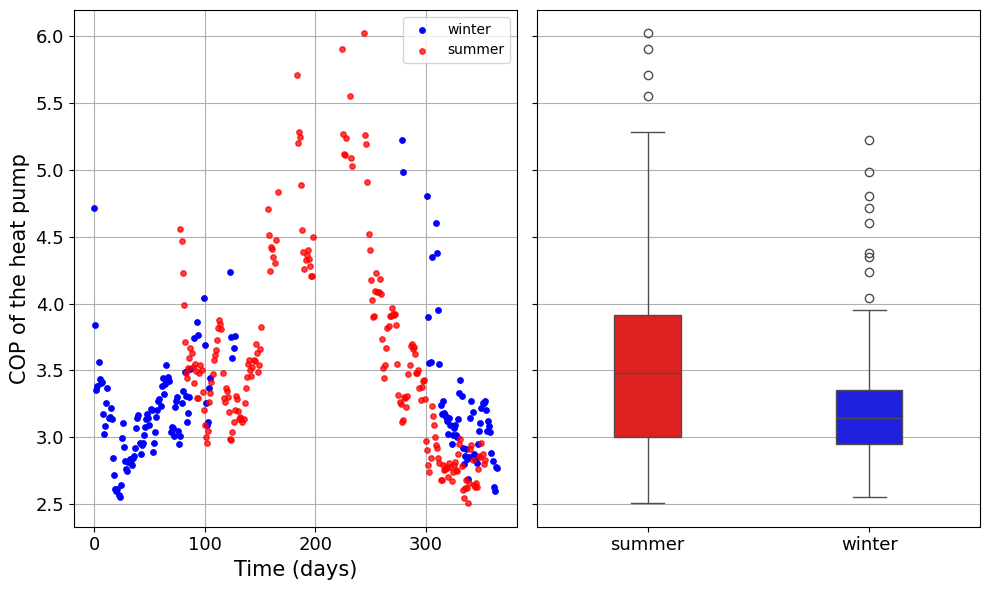

In [16]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

mask = df_result_winter["cop"] > 0
winter_cop = df_result_winter.loc[mask, "cop"]
ax[0].scatter(df_result_winter.loc[mask].index, winter_cop, color="blue", s=15, label="winter")


mask = df_result_summer["cop"] > 0
summer_cop = df_result_summer.loc[mask, "cop"]
ax[0].scatter(df_result_summer.loc[mask].index, summer_cop, color="red", alpha=0.75, s=15, label="summer")

df = pd.DataFrame(index=range(365), columns=["summer", "winter"])
df["summer"] = summer_cop
df["winter"] = winter_cop

sns.boxplot(df, ax=ax[1], width=0.3, palette=["r", "b"])

ax[0].set_ylabel("COP of the heat pump", size=15)
ax[0].set_xlabel("Time (days)", size=15)
ax[0].tick_params(axis="y", labelsize=13)
ax[0].tick_params(axis="x", labelsize=13)
ax[1].tick_params(axis="x", labelsize=13)
ax[0].grid()
ax[0].legend()
ax[1].yaxis.grid()
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

plt.tight_layout()

fig.savefig("COP_vs_time_and_boxplot.pdf")

## Histograms: Feed flow temperature, BHE outflow temperature, heat load

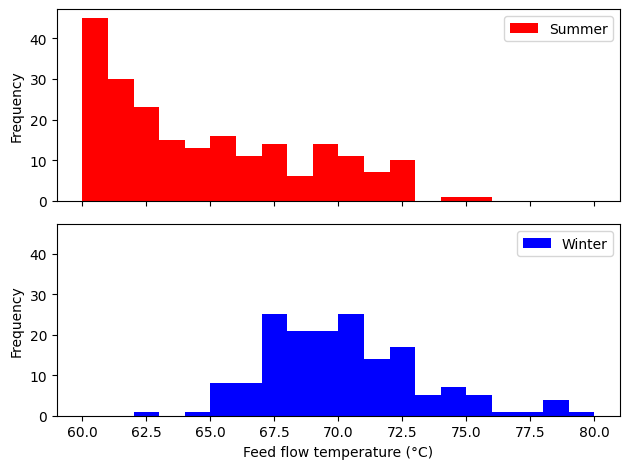

In [17]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

bins = np.arange(60, 81, 1)
mask = df_result_summer["cop"] > 0
df_daily_summer.loc[mask, "T_feed"].plot.hist(ax=ax[0], bins=bins, color="red", label="Summer")

mask = df_result_winter["cop"] > 0
df_daily_winter.loc[mask, "T_feed"].plot.hist(ax=ax[1], bins=bins, color="blue", label="Winter")

ax[0].legend()
ax[1].legend()

ax[1].set_xlabel("Feed flow temperature (°C)")

plt.tight_layout()

fig.savefig("histogram_feed_flow_temperature.pdf")

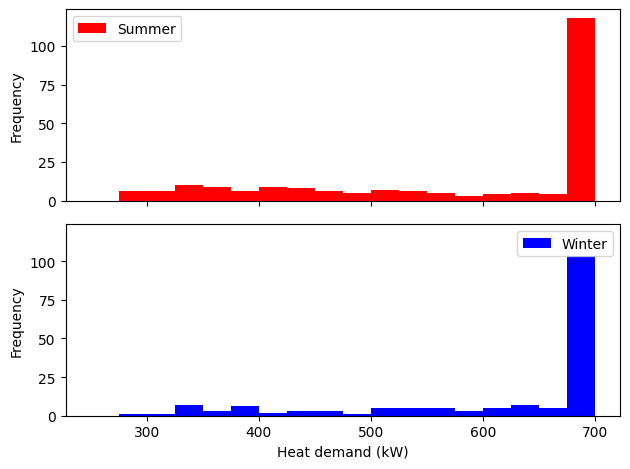

In [18]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

bins = np.arange(250, 701, 25)
mask = df_result_summer["cop"] > 0
df_result_summer.loc[mask, "heat"].plot.hist(ax=ax[0], bins=bins, color="red", label="Summer")

mask = df_result_winter["cop"] > 0
df_result_winter.loc[mask, "heat"].plot.hist(ax=ax[1], bins=bins, color="blue", label="Winter")

ax[0].legend()
ax[1].legend()

ax[1].set_xlabel("Heat demand (kW)")

plt.tight_layout()

fig.savefig("histogram_heat_demand.pdf")

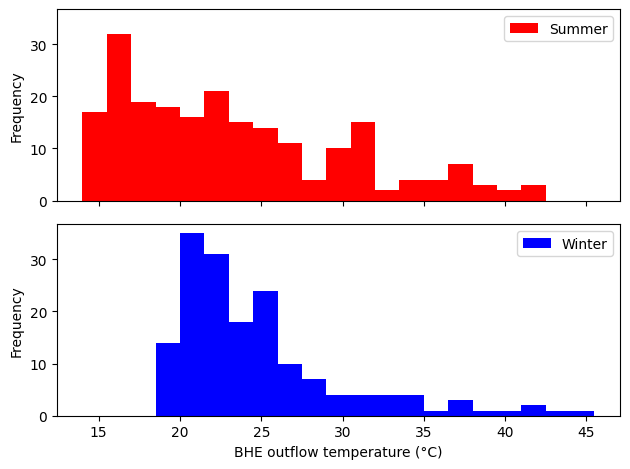

In [19]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

bins = np.arange(14, 47, 1.5)
mask = df_result_summer["cop"] > 0
df_result_summer.loc[mask, "T"].plot.hist(ax=ax[0], bins=bins, color="red", label="Summer")

mask = df_result_winter["cop"] > 0,
df_result_winter.loc[mask, "T"].plot.hist(ax=ax[1], bins=bins, color="blue", label="Winter")

ax[0].legend()
ax[1].legend()

ax[1].set_xlabel("BHE outflow temperature (°C)")

plt.tight_layout()

fig.savefig("histogram_bhe_outflow_temperature.pdf")

## Scatter plots: individual effect analysis

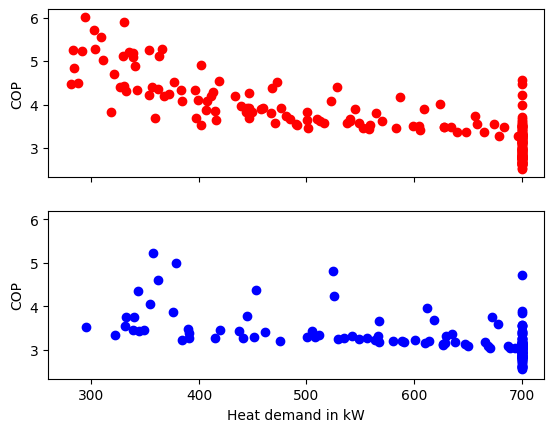

In [20]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "heat"], df_result_summer.loc[mask, "cop"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "heat"], df_result_winter.loc[mask, "cop"], color="blue")

[_.set_ylabel("COP") for _ in ax]

ax[1].set_xlabel("Heat demand in kW")

fig.savefig("COP_district_heating_temperature.pdf")

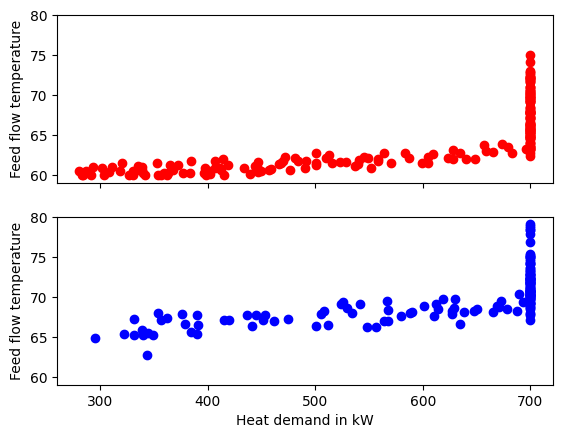

In [21]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "heat"], df_result_summer.loc[mask, "T_feed"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "heat"], df_result_winter.loc[mask, "T_feed"], color="blue")

[_.set_ylabel("Feed flow temperature") for _ in ax]

ax[1].set_xlabel("Heat demand in kW")

fig.savefig("Feed_flow_temperature_vs_heat_demand.pdf")

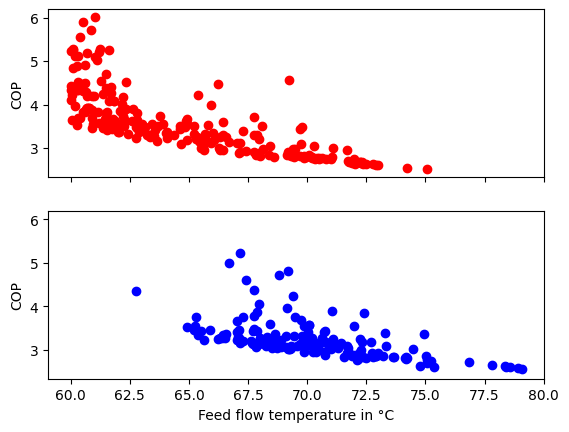

In [22]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "T_feed"], df_result_summer.loc[mask, "cop"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "T_feed"], df_result_winter.loc[mask, "cop"], color="blue")

[_.set_ylabel("COP") for _ in ax]

ax[1].set_xlabel("Feed flow temperature in °C")

fig.savefig("COP_vs_feed_flow_temperature.pdf")

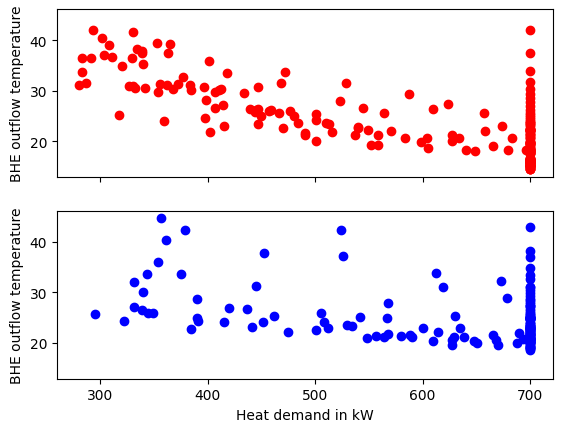

In [23]:

fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "heat"], df_result_summer.loc[mask, "T"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "heat"], df_result_winter.loc[mask, "T"], color="blue")

[_.set_ylabel("BHE outflow temperature") for _ in ax]

ax[1].set_xlabel("Heat demand in kW")

fig.savefig("BHE_outflow_vs_heat_demand.pdf")

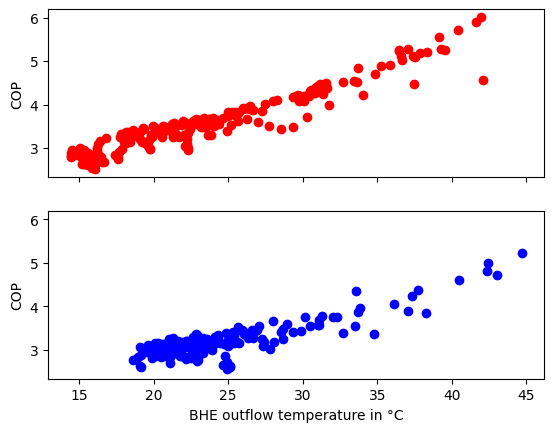

In [24]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "cop"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "cop"], color="blue")

[_.set_ylabel("COP") for _ in ax]

ax[1].set_xlabel("BHE outflow temperature in °C")

fig.savefig("COP_BHE_outflow_temperature.pdf")

## Scatter plots: Double effect analysis

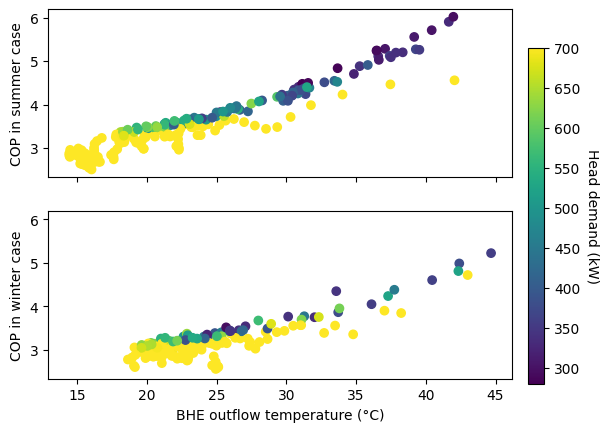

In [25]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0
_ = ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "cop"], vmin=280, vmax=700, c=df_result_summer.loc[mask, "heat"])

mask = df_result_winter["cop"] > 0
_ = ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "cop"], vmin=280, vmax=700, c=df_result_winter.loc[mask, "heat"])

fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.875, 0.1, 0.025, 0.7])
cbar = fig.colorbar(_, cax=cbar_ax)
cbar.ax.set_ylabel("Head demand (kW)", rotation=-90, va="bottom")

ax[0].set_ylabel("COP in summer case")
ax[1].set_ylabel("COP in winter case")

ax[1].set_xlabel("BHE outflow temperature (°C)")

fig.savefig("COP_vs_BHE_outflow_temperature_vs_heat_demand.pdf")

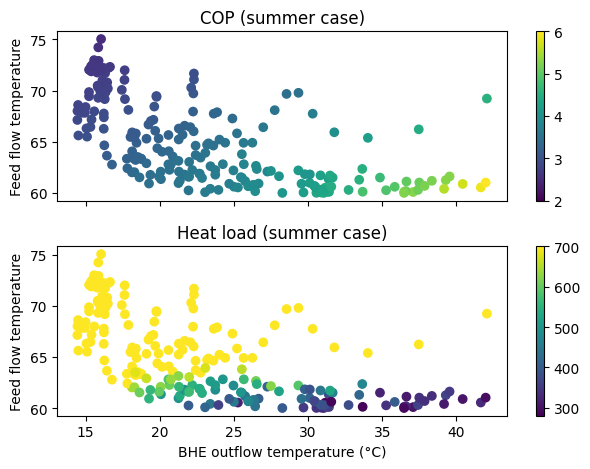

In [26]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

_ = ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "T_feed"], c=df_result_summer.loc[mask, "cop"], vmin=2, vmax=6)
cbar = fig.colorbar(_)

_ = ax[1].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "T_feed"], c=df_result_summer.loc[mask, "heat"], vmin=280, vmax=700)

cbar = fig.colorbar(_)

ax[0].set_title("COP (summer case)")
ax[0].set_ylabel("Feed flow temperature")

ax[1].set_title("Heat load (summer case)")
ax[1].set_ylabel("Feed flow temperature")
ax[1].set_xlabel("BHE outflow temperature (°C)")

plt.tight_layout()

fig.savefig("COP_vs_BHE_outflow_temperature_vs_feed_flow.pdf")

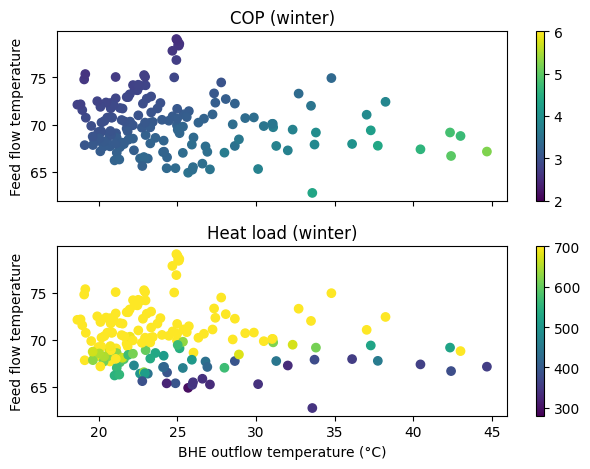

In [27]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_winter["cop"] > 0

_ = ax[0].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "T_feed"], c=df_result_winter.loc[mask, "cop"], vmin=2, vmax=6)
cbar = fig.colorbar(_)

_ = ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "T_feed"], c=df_result_winter.loc[mask, "heat"], vmin=280, vmax=700)

cbar = fig.colorbar(_)

ax[0].set_title("COP (winter)")
ax[0].set_ylabel("Feed flow temperature")

ax[1].set_title("Heat load (winter)")
ax[1].set_ylabel("Feed flow temperature")
ax[1].set_xlabel("BHE outflow temperature (°C)")

plt.tight_layout()

fig.savefig("COP_vs_BHE_outflow_temperature_vs_feed_flow.pdf")

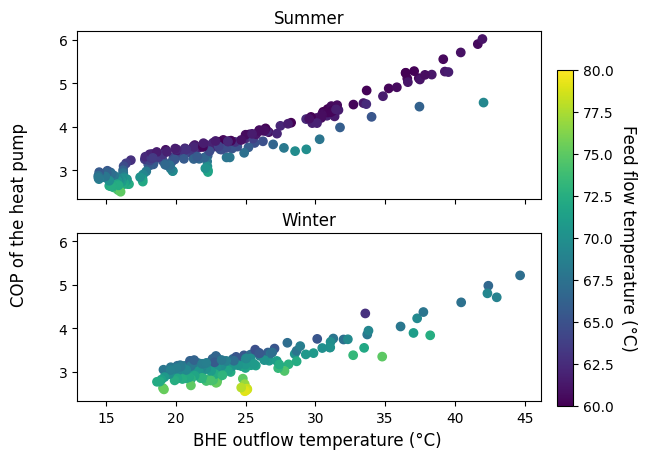

In [28]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0
_ = ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "cop"], c=df_result_summer.loc[mask, "T_feed"], vmin=60, vmax=80)

mask = df_result_winter["cop"] > 0
_ = ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "cop"], c=df_result_winter.loc[mask, "T_feed"], vmin=60, vmax=80)

fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.875, 0.1, 0.025, 0.7])
cbar = fig.colorbar(_, cax=cbar_ax)
cbar.ax.set_ylabel("Feed flow temperature (°C)", rotation=-90, va="bottom", size=12)

ax[0].set_title("Summer", size=12)
ax[1].set_title("Winter", size=12)
fig.supylabel("COP of the heat pump", size=12)
fig.supxlabel("BHE outflow temperature (°C)", size=12)

fig.savefig("COP_vs_T_BHE_outflow_vs_T_feed.pdf")

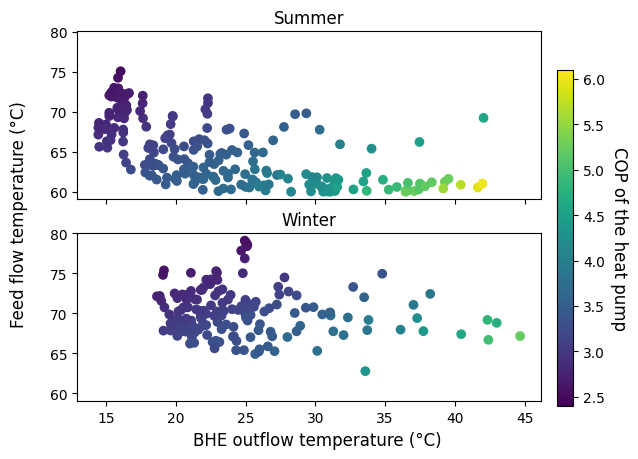

In [29]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0
_ = ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "T_feed"], c=df_result_summer.loc[mask, "cop"], vmin=2.4, vmax=6.1)

mask = df_result_winter["cop"] > 0
_ = ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "T_feed"], c=df_result_winter.loc[mask, "cop"], vmin=2.4, vmax=6.1)

fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.875, 0.1, 0.025, 0.7])
cbar = fig.colorbar(_, cax=cbar_ax)
cbar.ax.set_ylabel("COP of the heat pump", rotation=-90, va="bottom", size=12)

ax[0].set_title("Summer", size=12)
ax[1].set_title("Winter", size=12)
fig.supylabel("Feed flow temperature (°C)", size=12)
fig.supxlabel("BHE outflow temperature (°C)", size=12)

fig.savefig("T_feed_vs_T_BHE_outflow_vs_COP.pdf")